# King County Home Prices

Using regression to predict home prices.

Some information on the variables is available online:<br>
http://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [100]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(font_scale=1.25)

import os, sys
utilpath = os.path.abspath(os.path.join('..', 'mypyutil'))
sys.path.append(utilpath)
from InspectPandas import inspectdata

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [6]:
# load and inspect data

df = inspectdata('kc_house_data.csv.zip')
df.head()

Number of records:21,613
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Looks like there aren't any missing values.

In [27]:
# what are the categorical variables?
catvars = ['waterfront', 'view', 'condition', 'zipcode']

for var in catvars:
    print('')
    print(var)
    print(df[var].unique())


waterfront
[0 1]

view
[0 3 4 2 1]

condition
[3 5 4 1 2]

zipcode
[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


Based on the possible values, **condition** and **view** are likely ordinal variables. But without more information it is difficult to know with certainty.

**Waterfront** is likely a binary variable indicating if the property is on the waterfront or not, thus does not require encoding or additional processing.

Suggest checking correlation to see if variables are likely imporant.

In [58]:
# check for correlation with price for appropriate variables
# drop unprocessed variables

exclvars = ['id', 'zipcode', 'lat', 'long', 'date']

dfcont = df.drop(exclvars, axis=1)

dfcont.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138
view,0.397293
sqft_basement,0.323816
bedrooms,0.308350
waterfront,0.266369


In [104]:
# split dataset
y = dfcont['price']
X = dfcont.drop('price', axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [116]:
# ridge regression with standardized values
ss = StandardScaler()
ridge = RidgeCV(alphas=np.logspace(-5,5,11), cv=None, scoring='neg_mean_squared_error')
ridge.fit(ss.fit_transform(Xtrain), ytrain)

print('alpha = {0:.2g}'.format(ridge.alpha_))
pd.Series(ridge.coef_, index=X.columns).sort_values(ascending=False)

alpha = 1e+02


grade            135902.698664
sqft_living       74419.509225
sqft_above        62668.196625
waterfront        45624.726323
sqft_basement     36473.348659
bathrooms         36253.281793
view              34086.569573
sqft_living15     18059.268597
floors            14718.093761
condition         10547.738317
yr_renovated       5794.441138
sqft_lot          -1478.054159
sqft_lot15       -13462.495024
bedrooms         -35063.574753
yr_built        -103829.913262
dtype: float64

In [117]:
# lasso regression with standardized values
lasso = LassoCV(n_alphas=100, cv=5)
lasso.fit(ss.fit_transform(Xtrain), ytrain)

print('alpha = {0:.2g}'.format(lasso.alpha_))

pd.Series(lasso.coef_, index=X.columns).sort_values(ascending=False)

alpha = 2.5e+02


sqft_living      143924.515633
grade            137816.368004
waterfront        45709.536280
bathrooms         36242.254955
view              33906.390103
sqft_living15     16802.657840
floors            14211.151411
condition         10064.501377
yr_renovated       5294.824669
sqft_basement      2662.753874
sqft_above            0.000000
sqft_lot          -1319.263945
sqft_lot15       -13365.342050
bedrooms         -35023.514710
yr_built        -104883.901128
dtype: float64

In [118]:
# compare test set error
for reg, name in zip([ridge, lasso], ['ridge','lasso']):
    print('')
    print(name+' regression mse:')
    print('{0:.2g}'.format(mean_squared_error(ytest, reg.predict(ss.fit_transform(Xtest)))))


ridge regression mse:
5.2e+10

lasso regression mse:
5.2e+10


In [23]:
# describe each of the variables

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


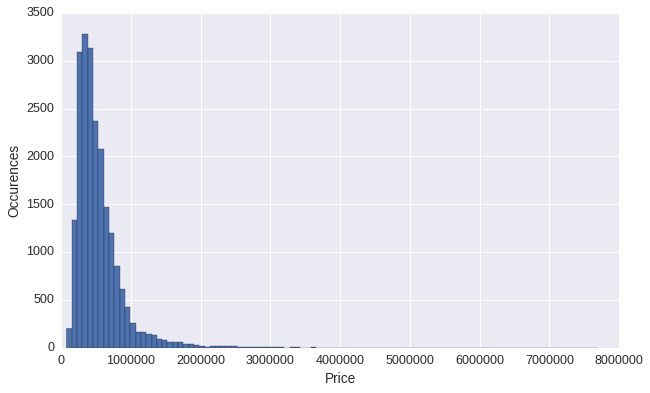

In [22]:
# distribution of prices

plt.figure(figsize=(10,6))
plt.xlabel('Price')
plt.ylabel('Occurences')
_ = df['price'].hist(bins=100)

In [10]:
# messing around with linear regression

linreg = smf.ols('price ~ bedrooms + bathrooms + sqft_above', data=df)
linreg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     4608.
Date:                Tue, 04 Oct 2016   Prob (F-statistic):               0.00
Time:                        15:21:56   Log-Likelihood:            -3.0226e+05
No. Observations:               21613   AIC:                         6.045e+05
Df Residuals:                   21609   BIC:                         6.046e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -1.419e+04   7603.727     -1.866      0.062     -2.91e+04   713.918
bedrooms   -1.121e+04   2497.769     -4.490      0.000     -1.61e+04 -6318.285
bathrooms   1.038e+05   3639.135     28.523      0.000      9.67e+04  1.11e+05
sqft_above   208.3276      3.300     63.127      0.000       201.859   214.796
==============================================================================
Omnibus:                    16377.858   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           727483.998
Skew:                           3.223   Prob(JB):                         0.00
Kurtosis:                      30.682   Cond. No.                     7.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""